In [19]:
import re
from igraph import *
from collections import defaultdict,Counter
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import json
import os
import networkx as nx
#from scipy import stats
from sklearn.metrics import auc
import vamb4
import torch as _torch


In [21]:
# load identifiers
dataset = 'oral'
composition = vamb4.parsecontigs.Composition.load('/Users/liuxinyuan/Desktop/master_thesis/new_graph/spades/oral/vambout/composition.npz')
identifiers = list(composition.metadata.identifiers)

In [23]:
# load ref file
with open('/Users/liuxinyuan/Desktop/master_thesis/data/oral/ref_20230425.json', 'r') as f:
        ref_obj = json.load(f)

In [9]:
with open('/Users/liuxinyuan/Desktop/master_thesis/data/oral/errorfree/ref.json', 'r') as f:
        ref_obj = json.load(f)

In [24]:
# create genome_contig and contig_genome dict
ref_genomes = ref_obj['genomes']
ref_sequences = ref_obj['sequences']

contig_sources = dict() # dictionary of contig:sources (1 to n mapping, some contigs have no source)
for contigid,_,info in ref_sequences:
    contig_sources[contigid] = [s[0] for s in info]

cp_genome_dict = dict() # dictionary of source:genome (1 to 1 mapping)
for genome_entry in ref_genomes:
    genome = genome_entry[0]
    for cp in genome_entry[2]:
        cp = cp[0]
        if cp not in cp_genome_dict.keys():
            cp_genome_dict[cp] = genome

contig_genomes = dict() # dictionary of contig:genomes (1 to n mapping, only include filtered contigs)
for contig in identifiers:
    contig_genomes[contig] = set()
    sources = contig_sources[contig]
    contig_genomes[contig] = contig_genomes[contig].union({cp_genome_dict[cp] for cp in sources})

genome_contigs = dict() # dictionary of genome:contigs, consider both contigs with 1 genome and more than 1
for contig, genomes in contig_genomes.items():
    for ge in genomes:
        if ge not in genome_contigs.keys():
            genome_contigs[ge] = {contig}
        else:
            genome_contigs[ge].add(contig)

In [ ]:
contig_genomes_2 = {}
for contig,genomes in contig_genomes.items():
    id =  identifiers.index(contig)
    contig_genomes_2[id] = list(contig_genomes[contig])

In [18]:
with open('contig_genomes_oral_ef.json','w') as f:
    json.dump(contig_genomes_2,f)

In [25]:
# create contig_length dict
def _contig_length(ref_obj,identifiers):
    contig_length = dict()
    contig_length_filter = dict()
    for seq in ref_obj['sequences']:
        seq_name = seq[0]
        seq_len = seq[1]
        contig_length[seq_name] = int(seq_len)
    for contig in identifiers:
        contig_length_filter[contig] = contig_length[contig]
    return contig_length_filter, contig_length
contig_lenght_d, contig_length_raw = _contig_length(ref_obj,identifiers)     # dictionary of contig:length             
len([contig for contig,len in contig_lenght_d.items()]), min(contig_lenght_d.values())


(70064, 2000)

In [26]:
def neighbors_dict_new(
        graph_path: str,
        identifiers: list,
):
    graph_dict = {}
    with open(graph_path,'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            id0 = parts[0]
            id1 = parts[1]
            if id0 in graph_dict.keys():
                graph_dict[id0] += [id1]
            else:
                graph_dict[id0] = [id1]

    return graph_dict

def dict_to_nx_graph(graph_dict):
    G = nx.Graph()
    G.add_nodes_from(graph_dict.keys())
    for node, neighbors in graph_dict.items():
        G.add_edges_from((node, neighbor) for neighbor in neighbors)
    return G

In [27]:
graph_path_5 = '/Users/liuxinyuan/Desktop/master_thesis/week9/new_assebgraph/{}/neighbours_dg_5.txt'.format(dataset)
graph_dict_5 = neighbors_dict_new(graph_path_5,list(identifiers))
graph_object_5 = dict_to_nx_graph(graph_dict_5)

In [28]:
graph_path_1 = '/Users/liuxinyuan/Desktop/master_thesis/week9/new_assebgraph/{}/neighbours_dg_1.txt'.format(dataset)
graph_dict_1 = neighbors_dict_new(graph_path_1,list(identifiers))
graph_object_1 = dict_to_nx_graph(graph_dict_1)

In [29]:
graph_path_10 = '/Users/liuxinyuan/Desktop/master_thesis/week9/new_assebgraph/{}/neighbours_dg_10.txt'.format(dataset)
graph_dict_10 = neighbors_dict_new(graph_path_10,list(identifiers))
graph_object_10 = dict_to_nx_graph(graph_dict_10)

In [30]:
nnei_list_1,nnei_list_5,nnei_list_10 = [],[],[]
for contig in identifiers:
    nnei_list_1.append(len(graph_object_1.edges(contig)))
    nnei_list_5.append(len(graph_object_5.edges(contig)))
    nnei_list_10.append(len(graph_object_10.edges(contig)))


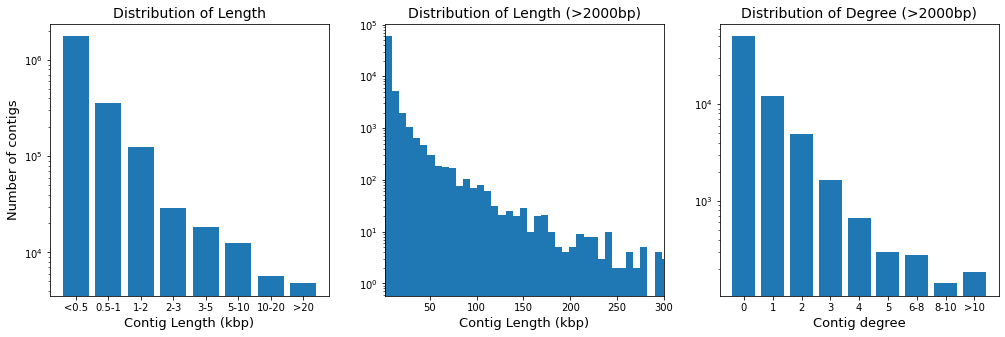

In [50]:
bins_l = [0, 500, 1000, 2000, 3000, 5000,10000, 20000, np.inf]
hist_l, _ = np.histogram(list(contig_length_raw.values()), bins=bins_l)
labels_l = ["<0.5", "0.5-1", "1-2", "2-3","3-5", "5-10", "10-20", ">20"]

bins_d = [0,1,2,3,4,5,6,8,10,np.inf]
hist_d, _ = np.histogram(nnei_list_1, bins=bins_d)
labels_d = ['0','1','2','3','4','5','6-8','8-10','>10']

plt.figure(figsize=(17,5))

plt.subplot(1,3,1)
# plt.hist(contig_length_raw.values(),bins=bins_l)
plt.bar(labels_l, hist_l)
plt.yscale('log')
plt.xlabel("Contig Length (kbp)",fontdict={"fontsize": 13})
plt.ylabel("Number of contigs",fontdict={"fontsize": 13})
plt.title("Distribution of Length",fontdict={"fontsize": 14})

plt.subplot(1,3,2)
plt.hist(np.array(list(contig_lenght_d.values()))/1000,bins=100)
plt.yscale('log')
# plt.xscale('log')
plt.xlim((2,300))
plt.xlabel("Contig Length (kbp)",fontdict={"fontsize": 13})
plt.title("Distribution of Length (>2000bp)",fontdict={"fontsize": 14})

plt.subplot(1,3,3)
# plt.hist(nnei_list_1,bins=)
plt.bar(labels_d, hist_d)
plt.yscale('log')
plt.xlabel("Contig degree",fontdict={"fontsize": 13})
plt.title("Distribution of Degree (>2000bp)",fontdict={"fontsize": 14})

plt.savefig('Len_deg_distri.png',dpi=300)

In [162]:
# calculate TP ratios overall
def calc_TPratio(graph_object):
    edges_btw_contigs_without_genomes,edges_btw_contigs_with_genomes = 0,0
    TP_edge = 0
    nedges = len(graph_object.edges())
    for edge_pair in graph_object.edges():
        c1, c2 = edge_pair
        if (len(contig_genomes[c1]) == 0 or len(contig_genomes[c2]) == 0):
            edges_btw_contigs_without_genomes += 1
            continue
        else:
            edges_btw_contigs_with_genomes += 1
        if len(contig_genomes[c1].intersection(contig_genomes[c2])) > 0:
            TP_edge += 1
    return TP_edge/edges_btw_contigs_with_genomes, edges_btw_contigs_with_genomes, edges_btw_contigs_without_genomes, TP_edge

In [163]:
calc_TPratio(graph_object_1),calc_TPratio(graph_object_5),calc_TPratio(graph_object_10)

((0.6895342632822624, 13119, 5051, 9046),
 (0.767621923793613, 31126, 10672, 23893),
 (0.8211399782673121, 50615, 13681, 41562))

In [109]:
# plot TP ratio vs. length range
def plot_TPs_genome_prtgs(
    graph_object:Graph,
    genome_contigs_d: dict[str,list[str]],
    contig_genomes_d: dict[str,list[str]],
    plot_title: str,
    outfile: str,
    ):
    edges_btw_contigs_without_genomes = 0
    edges_btw_contigs_with_genomes = 0

    # For each edge, 
    contig_hit_d = dict()
    for edges_pair in graph_object.edges():
        # Extract contigs connected per edge
        c1, c2 = edges_pair
        
        # if any of the contigs does not map to a genome/plasmid, skip edge
        if (len(contig_genomes_d[c1]) == 0 or len(contig_genomes_d[c2]) == 0):
            edges_btw_contigs_without_genomes += 1
            continue
        else:
            edges_btw_contigs_with_genomes += 1
        # get contig lengths
        c1_len , c2_len = contig_lenght_d[c1] , contig_lenght_d[c2]
        # Find shortest length
        min_len = min(c1_len,c2_len)
        # Find which is the idx of the shortest contig
        shortest_contig_idx = np.argmin([[c1_len,c2_len]])
        # Define the shortes contig
        shortest_contig = edges_pair[shortest_contig_idx]
        if shortest_contig not in contig_hit_d.keys():
            contig_hit_d[shortest_contig] = []
        # if connected contigs map to a common genome
        if len(contig_genomes_d[c1].intersection(contig_genomes_d[c2])) > 0:
            # add a hit for the shortest contig
            contig_hit_d[shortest_contig] += [1]
        # If they do not have any genome in common
        else:
            #hits.append(0)
            # add a zero
            contig_hit_d[shortest_contig] += [0]

    # For pair of contigs connected by an edge, evaluate if the shortest contig belongs to the same genome than the largest
    # Do it per ranges of contig lengths
    fig , ax = plt.subplots(nrows = 2, ncols=1, sharex='col', figsize = (4,8))

    i=0
    for min_len, max_len in zip([2000,5000,10000,20000,30000,50000,75000,100000,150000,200000,250000],[5000,10000,20000,30000,50000,75000,100000,150000,200000,250000,np.inf]):

        counter = Counter([element for contig,hits in contig_hit_d.items() if (min_len < contig_lenght_d[contig] < max_len) for element in hits])

        hits = counter[1] # TP edges
        misses = counter[0] # FP edges
        
        ax[0].bar(i,hits,color='green')
        ax[0].bar(i,misses,bottom=hits, color='brown')
        if i == 6:
            ax[0].bar(i,hits,color='green', label='TP')
            ax[0].bar(i,misses,bottom=hits, color='brown',label='FP')

        else:
            ax[0].bar(i,misses,bottom=hits, color='brown')
        if (hits+misses) == 0:
            i += 1
            print(hits,misses,min_len,max_len)
            continue
        else:
            ax[1].bar(i, hits/(misses+hits),color='navy')
            print(hits,misses,min_len,max_len,np.round(hits/(misses+hits),4))

        i += 1

    ax[0].legend()
    ax[0].set_ylim([1e0,1e5])
    ax[0].set_title('%s'%(plot_title),fontdict={"fontsize": 16})
    ax[0].set_yscale('log')

    # ax[0].set_ylabel('Number of TP and FP edges',fontdict={"fontsize": 14})
    ax[1].set_xticks(
        range(11),
        labels='2-5 5-10 10-20 20-30 30-50 50-75 75-100 100-150 150-200 200-250 >250'.split(),
        rotation=45,
        fontsize=10)
    ax[1].set_ylim([0,1.1])
    # ax[1].set_ylabel('TP ratios (TP/TP+FP)',fontdict={"fontsize": 14})
    ax[1].set_xlabel('Length of contigs (kbp)',fontdict={"fontsize": 14})
    plt.tight_layout()
    # print('%i contigs in the graph'%(total_contigs))
    print('%i edges connect contigs that map to no genome'%(edges_btw_contigs_without_genomes))
    print('%i edges connect contigs that map to genome'%(edges_btw_contigs_with_genomes))

    plt.savefig(outfile,dpi=300)

4769 2607 2000 5000 0.6466
1976 795 5000 10000 0.7131
1115 432 10000 20000 0.7207
451 118 20000 30000 0.7926
439 87 30000 50000 0.8346
191 17 50000 75000 0.9183
55 11 75000 100000 0.8333
22 2 100000 150000 0.9167
10 0 150000 200000 1.0
3 1 200000 250000 0.75
3 1 250000 inf 0.75
5051 edges connect contigs that map to no genome
13119 edges connect contigs that map to genome


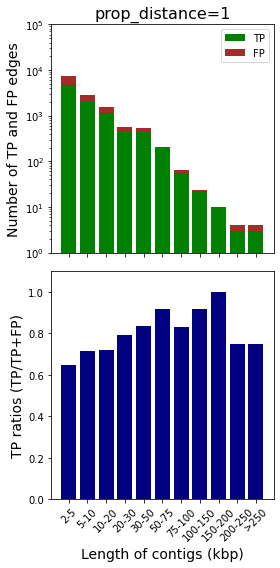

In [108]:
plot_TPs_genome_prtgs(graph_object_1,genome_contigs,contig_genomes,'prop_distance=1','stat_plots/TP_Length_1.png')

13963 4770 2000 5000 0.7454
5397 1355 5000 10000 0.7993
2566 706 10000 20000 0.7842
824 188 20000 30000 0.8142
706 149 30000 50000 0.8257
253 35 50000 75000 0.8785
90 18 75000 100000 0.8333
49 6 100000 150000 0.8909
18 0 150000 200000 1.0
5 1 200000 250000 0.8333
3 2 250000 inf 0.6
10672 edges connect contigs that map to no genome
31126 edges connect contigs that map to genome


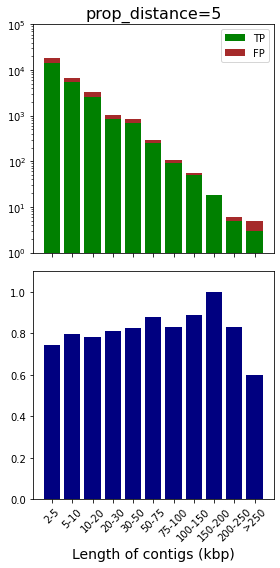

In [111]:
plot_TPs_genome_prtgs(graph_object_5,genome_contigs,contig_genomes,'prop_distance=5','stat_plots/TP_Length_5.png')

27675 6314 2000 5000 0.8142
8625 1523 5000 10000 0.8499
3185 763 10000 20000 0.8067
904 212 20000 30000 0.81
724 165 30000 50000 0.8144
255 42 50000 75000 0.8586
91 21 75000 100000 0.8125
49 6 100000 150000 0.8909
19 0 150000 200000 1.0
5 1 200000 250000 0.8333
3 2 250000 inf 0.6
13681 edges connect contigs that map to no genome
50615 edges connect contigs that map to genome


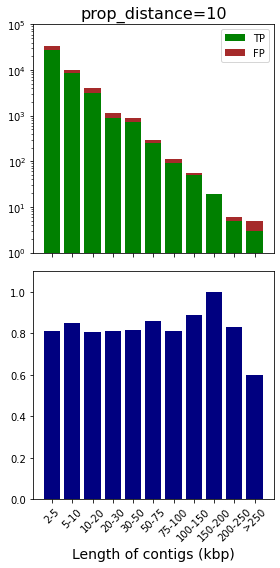

In [110]:
plot_TPs_genome_prtgs(graph_object_10,genome_contigs,contig_genomes,'prop_distance=10','stat_plots/TP_Length_10.png')

In [199]:
# plot depend-contig ratio distribution
def plot_ndepend_genome(    
    graph_object:Graph,
    genome_contigs_d: dict[str,list[str]],
    contig_genomes_d: dict[str,list[str]],
    plot_title: str,
    ):

    selected_genomes = []
    min_prc_contigs_with_nghs = 0.99
    min_neighs = 1
    prc_contigs_with_ngs = []
    total_contigs = 0
    mean_TP_dict = {}
    for genome,contigs in genome_contigs_d.items():
        contigs_with_nghs, contigs_without_nghs = 0, 0
        TP_list = []
        for contig in contigs:
            # filter contig mapping no genome
            if len(contig_genomes_d[contig]) == 0:
                continue
            total_contigs += 1
            # calculate number of neighbors
            if isinstance(graph_object,nx.classes.digraph.DiGraph):
                n_neighs = len(graph_object.in_edges(contig))+len(graph_object.out_edges(contig))
            else:
                n_neighs = len(graph_object.edges(contig)) # if have no neighbor and not in nodes, shows 0
            
            # contig have neighbors
            if n_neighs >= min_neighs:
                contigs_with_nghs += 1
                # calculate TP ratio
                nnei_same = 0
                for edge in graph_object.edges(contig):
                    _,nei = edge
                    if len(contig_genomes_d[contig].intersection(contig_genomes_d[nei])) > 0:
                        nnei_same += 1
                    TP_list.append(nnei_same/n_neighs)

            # contig have no neighbor
            else:
                contigs_without_nghs = 0

        # calculate average TP ratio
        mean_TP_dict[genome] = mean(TP_list)

        if (contigs_with_nghs + contigs_without_nghs > 0):
            # calculate the percentage of dependent contigs in the whole genome
            prc_contigs_with_ngs.append((contigs_with_nghs/len(contigs))*100)

            if (contigs_with_nghs/len(contigs)) > min_prc_contigs_with_nghs:
                selected_genomes.append(genome)
        else: # there are no dependent contig
            prc_contigs_with_ngs.append(0)
        

    # print(selected_genomes)
    plt.hist(prc_contigs_with_ngs,bins=np.arange(101))
    plt.title('%s'%(plot_title),fontdict={"fontsize":15})
    if plot_title == 'prop_distance=1':
        plt.ylabel('Number of genomes',fontdict={"fontsize":14})
    plt.xlabel('Dependent-contig(d>0) ratio (%)',fontdict={"fontsize":14})

    return mean_TP_dict


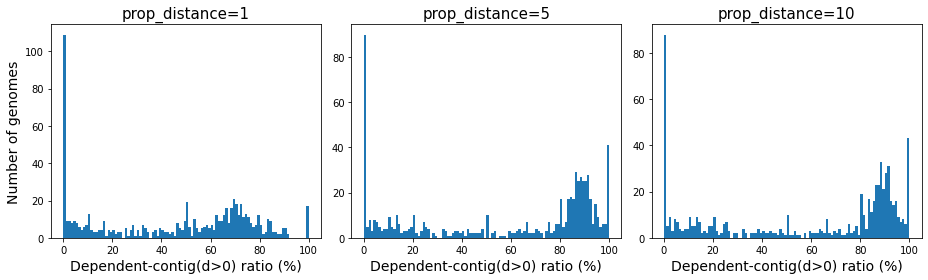

In [200]:
graph_object_list = [graph_object_1,graph_object_5,graph_object_10]
plot_title_list = ['prop_distance=1','prop_distance=5','prop_distance=10']
mean_TP_dict_list = []
plt.figure(figsize=(13,4))
for i, graph_object in enumerate(graph_object_list):
    plt.subplot(1,3,i+1)
    mean_TP_dict = plot_ndepend_genome(graph_object,genome_contigs,contig_genomes,plot_title_list[i])
    mean_TP_dict_list.append(mean_TP_dict)
plt.tight_layout()
# plt.savefig('depc_ratio.png',dpi=300)

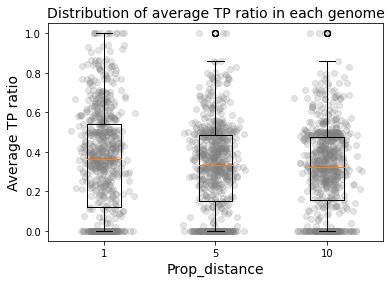

In [205]:
combined = [list(mean_TP_dict.values()) for mean_TP_dict in mean_TP_dict_list]
plt.figure(figsize=(6,4))
plt.boxplot(combined)
for i,data in enumerate(combined):
    offset = np.random.normal(loc=i, scale=0.1, size=len(data))
    plt.scatter(np.ones(len(data)) + offset, data, alpha=0.2, color='grey')
x_label = ['1','5','10']
loc = range(1,len(x_label)+1)
plt.xticks(loc, x_label)
plt.xlabel('Prop_distance',fontdict={'fontsize':14})
plt.ylabel('Average TP ratio',fontdict={'fontsize':14})
plt.title('Distribution of average TP ratio in each genome',fontdict={'fontsize':14})
plt.savefig('TPR_genome.png',dpi=300)


In [206]:
def plot_TPs_degree(
    graph_object:Graph,
    contig_genomes_d: dict[str,list[str]],
    plot_title: str,
    ):
    TP_dict = {}
    deg_dict = {}
    for i in graph_object.nodes():
        if len(contig_genomes_d[i]) == 0:
            continue
        nnei_same = 0
        d_i = len(graph_object.edges(i))
        deg_dict[i] = d_i
        total_edge = 0
        for edge in graph_object.edges(i):
            _,nei = edge
            if len(contig_genomes_d[i].intersection(contig_genomes_d[nei])) > 0:
                nnei_same += 1
            if len(contig_genomes_d[nei]) > 0:
                total_edge += 1
            TP_dict[i] = nnei_same/d_i
    x_label = ['1-2','2-5','5-10','10-20','20-30','>30']
    TPR_list = []
    mean_TPR_list = []
    ncontigs = []
    TPR_all = []
    for min_d, max_d in zip([1,2,5,10,20,30],[2,5,10,20,30,np.inf]):
        TPR_i = [TP_ratio for contig,TP_ratio in TP_dict.items() if (min_d <= deg_dict[contig] < max_d)]
        TPR_list.append(TPR_i)
        ncontigs.append(len(TPR_i))
        mean_TPR_list.append(mean(TPR_i))
        TPR_all += TPR_i
    mean_TPR_list.append(mean(TPR_all))

    plt.boxplot(TPR_list)
    for i,data in enumerate(TPR_list):
        offset = np.random.normal(loc=i, scale=0.1, size=len(data))
        plt.scatter(np.ones(len(data)) + offset, data, alpha=0.2, color='grey')

    loc = range(1,len(x_label)+1)
    plt.xticks(loc, x_label)
    plt.xlabel('Degree (number of neighbors)')
    plt.ylabel('TP ratio')
    plt.title(plot_title)

    return mean_TPR_list, ncontigs




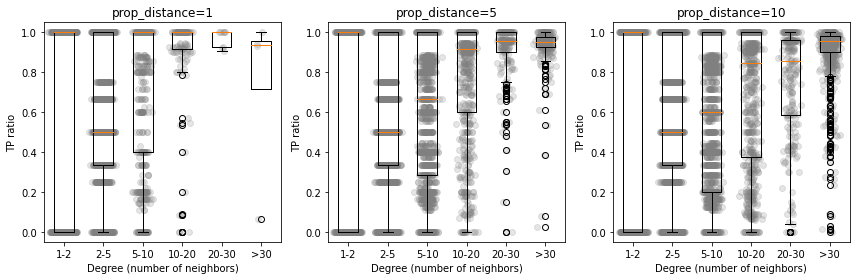

In [207]:
plt.figure(figsize=(12,4))
mean_TPR_forall = {}
ncontigs_forall = {}
for i, graph_object in enumerate(graph_object_list):
    plt.subplot(1,3,i+1)
    mean_TPR, ncontigs = plot_TPs_degree(graph_object,contig_genomes,plot_title_list[i])
    mean_TPR_forall[plot_title_list[i]] = mean_TPR
    ncontigs_forall[plot_title_list[i]] = ncontigs
plt.tight_layout()
# plt.savefig('TP_degree.png',dpi=300)

In [208]:
TPR_degree = np.array(list(mean_TPR_forall.values()))
import pandas as pd
TPR_d_tb = pd.DataFrame(TPR_degree,index=plot_title_list)


In [174]:
ncontigs_np = np.array(list(ncontigs_forall.values()))
sum_ncontigs = ncontigs_np.sum(axis=1).reshape(len(ncontigs_np),1)
ncontigs_np = np.concatenate((ncontigs_np,sum_ncontigs),axis=1)
ncontigs_df = pd.DataFrame(ncontigs_np,index=plot_title_list)

In [209]:
col_label = ['1-2','2-5','5-10','10-20','20-30','>30','Overall']
TPR_d_tb.set_axis(col_label,axis='columns')

,1-2,2-5,5-10,10-20,20-30,>30,Overall
prop_distance=1,0.540038,0.569339,0.724369,0.908256,0.972934,0.735177,0.560497
prop_distance=5,0.548678,0.572818,0.615048,0.767065,0.903145,0.931626,0.579099
prop_distance=10,0.547509,0.566420,0.579397,0.682165,0.750802,0.905746,0.577186


In [175]:
col_label = ['1-2','2-5','5-10','10-20','20-30','>30','all']
ncontigs_df.set_axis(col_label,axis='columns')

,1-2,2-5,5-10,10-20,20-30,>30,all
prop_degree=1,10053,5687,586,158,9,4,16497
prop_degree=5,9306,9320,1713,670,208,246,21463
prop_degree=10,9114,9140,1602,734,260,740,21590


In [177]:
TPR_d_tb.to_csv('stat_plots/TPratio_degree_tb.csv',index=True)

In [178]:
ncontigs_df.to_csv('stat_plots/ncon_deg.csv',index=True)